**Brian Blaylock**  
*January 27, 2022*

# ECMWF Open Data -- Real Time

This data is freely available from ECMWF in GRIB2 format ([read more 👀](https://confluence.ecmwf.int/display/UDOC/ECMWF+Open+Data+-+Real+Time)).

There following prodcuts are available:
- `"oper"` - operational high-resolution forecast, atmospheric fields
- `"enfo"` - ensemble forecast, atmospheric fields
- `"wave"` - wave forecasts
- `"waef"` - ensemble forecast, ocean wave fields


In [34]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np

from herbie.archive import Herbie

# The following are imported from
# https://github.com/blaylockbk/Carpenter_Workshop
from paint.standard2 import cm_tmp, cm_wind, cm_wave_height
from toolbox.cartopy_tools import common_features, pc


## Retrieve a full file
Download a full GRIB2 file to your local system.

In [35]:
H = Herbie("2022-01-26", model="ecmwf", product="oper")
H.download()


🏋🏻‍♂️ Found 2022-Jan-26 00:00 UTC F00 [ECMWF] [product=oper] GRIB2 file from local and index file from azure.                                                                                                                                                       
🌉 Already have local copy --> /p/cwfs/blaylock/data/ecmwf/20220126/20220126000000-0h-oper-fc.grib2


## Download/Retrieve a subset

This relys on the `searchString` argument to parse out information from the GRIB2's index file. The ECMWF index files are different than the wgrib2-style index files, so pay close attention to how you should select the field you want.

In [3]:
# Show the searchString_help
print(H.searchString_help)



Use regular expression to search for lines in the index file.
Here are some examples you can use for the grib_ls-style `searchString`

Look at the ECMWF GRIB Parameter Database
https://apps.ecmwf.int/codes/grib/param-db

======================== ==============================================
searchString (oper/enso) Messages that will be downloaded
======================== ==============================================
":2t:"                   2-m temperature
":10u:"                  10-m u wind vector
":10v:"                  10-m v wind vector
":10(u|v):               **10m u and 10m v wind**
":d:"                    Divergence
":gh:"                   geopotential height (all levels)
":st:"                   soil temperature
":tp:"                   total precipitation
":msl:"                  mean sea level pressure
":q:"                    Specific Humidity
":r:"                    relative humidity
":ro:"                   Runn-off
":skt:"                  skin temperature
":sp:

In [38]:
# Look at the search_this column of the index DataFrame
H.read_idx().search_this

grib_message
1     :gh:925:pl:g:0001:od:fc:oper
2        :st:sfc:g:0001:od:fc:oper
3        :tp:sfc:g:0001:od:fc:oper
4       :skt:sfc:g:0001:od:fc:oper
5      :r:250:pl:g:0001:od:fc:oper
                  ...             
78    :vo:200:pl:g:0001:od:fc:oper
79    :vo:250:pl:g:0001:od:fc:oper
80       :ro:sfc:g:0001:od:fc:oper
81      :d:50:pl:g:0001:od:fc:oper
82     :vo:50:pl:g:0001:od:fc:oper
Name: search_this, Length: 82, dtype: object

In [4]:
ds = H.xarray(":2t:")


📇 Download subset: [ECMWF] model [oper] product run at 2022-Jan-26 00:00 UTC F00                                                            
 cURL from file:///p/cwfs/blaylock/data/ecmwf/20220126/20220126000000-0h-oper-fc.grib2
   1: GRIB_message=40  :2t:sfc:g:0001:od:fc:oper


In [5]:
ds


<xarray.Dataset>
Dimensions:              (latitude: 451, longitude: 900)
Coordinates:
    time                 datetime64[ns] 2022-01-26
    step                 timedelta64[ns] 00:00:00
    heightAboveGround    float64 2.0
  * latitude             (latitude) float64 90.0 89.6 89.2 ... -89.2 -89.6 -90.0
  * longitude            (longitude) float64 -180.0 -179.6 ... 179.2 179.6
    valid_time           datetime64[ns] 2022-01-26
Data variables:
    t2m                  (latitude, longitude) float32 246.3 246.3 ... 246.4
    gribfile_projection  object None
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    model:                   ecmwf
    product:                 oper
    description:             ECMWF open data
    remote_grib:             /p/cwfs/blaylock/data/ecmwf/20220126/20220126000...
    local_grib:              /p/cwfs/blaylock/data/ecmwf/20220126/20220126000...

## Plots

/p/home/blaylock/anaconda3/envs/herbie/lib/python3.9/site-packages/metpy/xarray.py:349: UserWarning: More than one time coordinate present for variable "gribfile_projection".
  warnings.warn('More than one ' + axis + ' coordinate present for variable'


Text(1.0, 1.0, '2 metre temperature')

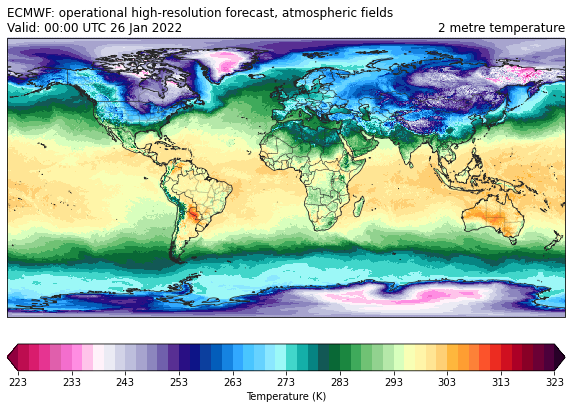

In [6]:
ax = common_features("50m", crs=ds.herbie.crs, figsize=[10, 10]).STATES().BORDERS().ax
p = ax.pcolormesh(
    ds.longitude, ds.latitude, ds.t2m, transform=pc, **cm_tmp(units="K").cmap_kwargs
)
plt.colorbar(
    p, ax=ax, orientation="horizontal", pad=0.05, **cm_tmp(units="K").cbar_kwargs
)

ax.set_title(
    f"{ds.model.upper()}: {H.product_description}\nValid: {ds.valid_time.dt.strftime('%H:%M UTC %d %b %Y').item()}",
    loc="left",
)
ax.set_title(ds.t2m.GRIB_name, loc="right")


In [28]:
H = Herbie("2022-01-26", model="ecmwf", product="oper")

# Get u and v wind component
ds = H.xarray(":10(u|v):")

# Compute the wind speed
ds["spd"] = np.sqrt(ds["u10"] ** 2 + ds["v10"] ** 2)
# wihtout too much thought, just quickly copy attributes
ds["spd"].attrs = ds["u10"].attrs.copy()
ds["spd"].attrs["standard_name"] = "wind_speed"
ds["spd"].attrs["long_name"] = "10 m wind speed"
ds["spd"].attrs["GRIB_name"] = "10 m Wind Speed"


ds


🏋🏻‍♂️ Found 2022-Jan-26 00:00 UTC F00 [ECMWF] [product=oper] GRIB2 file from local and index file from azure.                                                                                                                                                       
📇 Download subset: [ECMWF] model [oper] product run at 2022-Jan-26 00:00 UTC F00                                                            
 cURL from file:///p/cwfs/blaylock/data/ecmwf/20220126/20220126000000-0h-oper-fc.grib2
   1: GRIB_message=34  :10v:sfc:g:0001:od:fc:oper
   2: GRIB_message=39  :10u:sfc:g:0001:od:fc:oper


/p/home/blaylock/BB_python/Herbie/herbie/archive.py:683: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  logic = df.search_this.str.contains(searchString)


<xarray.Dataset>
Dimensions:              (latitude: 451, longitude: 900)
Coordinates:
    time                 datetime64[ns] 2022-01-26
    step                 timedelta64[ns] 00:00:00
    heightAboveGround    float64 10.0
  * latitude             (latitude) float64 90.0 89.6 89.2 ... -89.2 -89.6 -90.0
  * longitude            (longitude) float64 -180.0 -179.6 ... 179.2 179.6
    valid_time           datetime64[ns] 2022-01-26
Data variables:
    u10                  (latitude, longitude) float32 8.174 8.174 ... -5.998
    v10                  (latitude, longitude) float32 3.499 3.499 ... 3.733
    gribfile_projection  object None
    spd                  (latitude, longitude) float32 8.891 8.891 ... 7.065
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    model:                   ecmwf
    product:                 oper
    description:             ECMWF open data
    remote_grib:             /p/cwfs/blaylock/data/ecmwf/20220126/20220126000...
    local_grib:              /p/cwfs/blaylock/data/ecmwf/20220126/20220126000...

/p/home/blaylock/anaconda3/envs/herbie/lib/python3.9/site-packages/metpy/xarray.py:349: UserWarning: More than one time coordinate present for variable "gribfile_projection".
  warnings.warn('More than one ' + axis + ' coordinate present for variable'


Text(1.0, 1.0, '10 m Wind Speed')

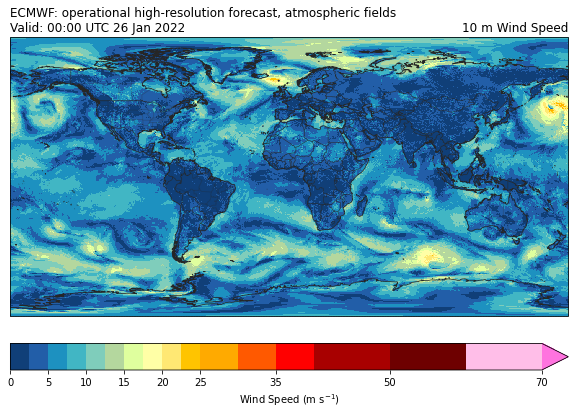

In [29]:
ax = common_features("50m", crs=ds.herbie.crs, figsize=[10, 10]).STATES().BORDERS().ax
p = ax.pcolormesh(
    ds.longitude, ds.latitude, ds.spd, transform=pc, **cm_wind().cmap_kwargs
)
plt.colorbar(p, ax=ax, orientation="horizontal", pad=0.05, **cm_wind().cbar_kwargs)

ax.set_title(
    f"{ds.model.upper()}: {H.product_description}\nValid: {ds.valid_time.dt.strftime('%H:%M UTC %d %b %Y').item()}",
    loc="left",
)
ax.set_title(ds.spd.GRIB_name, loc="right")


In [9]:
# Get 500 hPa specific humidity and geopotential height
ds = H.xarray(":(q|gh):500")
ds


/p/home/blaylock/BB_python/Herbie/herbie/archive.py:683: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  logic = df.search_this.str.contains(searchString)


📇 Download subset: [ECMWF] model [oper] product run at 2022-Jan-26 00:00 UTC F00                                                            
 cURL from file:///p/cwfs/blaylock/data/ecmwf/20220126/20220126000000-0h-oper-fc.grib2
   1: GRIB_message=29  :gh:500:pl:g:0001:od:fc:oper
   2: GRIB_message=48  :q:500:pl:g:0001:od:fc:oper


/p/home/blaylock/BB_python/Herbie/herbie/archive.py:683: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  logic = df.search_this.str.contains(searchString)


<xarray.Dataset>
Dimensions:              (latitude: 451, longitude: 900)
Coordinates:
    time                 datetime64[ns] 2022-01-26
    step                 timedelta64[ns] 00:00:00
    isobaricInhPa        float64 500.0
  * latitude             (latitude) float64 90.0 89.6 89.2 ... -89.2 -89.6 -90.0
  * longitude            (longitude) float64 -180.0 -179.6 ... 179.2 179.6
    valid_time           datetime64[ns] 2022-01-26
Data variables:
    q                    (latitude, longitude) float32 6.679e-05 ... 0.0001641
    gh                   (latitude, longitude) float32 5.029e+03 ... 5.136e+03
    gribfile_projection  object None
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    model:                   ecmwf
    product:                 oper
    description:             ECMWF open data
    remote_grib:             /p/cwfs/blaylock/data/ecmwf/20220126/20220126000...
    local_grib:              /p/cwfs/blaylock/data/ecmwf/20220126/20220126000...

Text(1.0, 1.0, '500.0 hPa\nSpecific humidity/Geopotential Height')

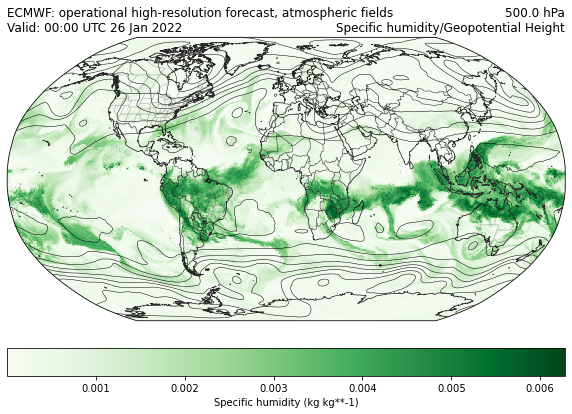

In [10]:
ax = common_features("50m", crs=ccrs.Robinson(), figsize=[10, 10]).STATES().BORDERS().ax

# Color shade by specific humidity
p = ax.pcolormesh(ds.longitude, ds.latitude, ds.q, transform=pc, cmap="Greens")

plt.colorbar(
    p,
    ax=ax,
    orientation="horizontal",
    pad=0.05,
    label=f"{ds.q.GRIB_name} ({ds.q.units})",
)

# Contours for geopotential height
ax.contour(
    ds.longitude,
    ds.latitude,
    ds.gh,
    transform=pc,
    colors="k",
    linewidths=.5,
    levels=range(0,10_000,60*2)
)


ax.set_title(
    f"{ds.model.upper()}: {H.product_description}\nValid: {ds.valid_time.dt.strftime('%H:%M UTC %d %b %Y').item()}",
    loc="left",
)
ax.set_title(
    f"{ds.isobaricInhPa.item()} {ds.isobaricInhPa.units}\n{ds.q.GRIB_name}/{ds.gh.GRIB_name}", loc="right"
)


## ECMWF Wave Output

In [11]:
H = Herbie('2022-01-26 00:00', model='ecmwf', product='wave')

🏋🏻‍♂️ Found 2022-Jan-26 00:00 UTC F00 [ECMWF] [product=wave] GRIB2 file from azure and index file from azure.                                                                                                                                                       


In [12]:
ds = H.xarray(None)

✅ Success! Downloaded ECMWF from azure               
	src: https://ai4edataeuwest.blob.core.windows.net/ecmwf/20220126/00z/0p4-beta/wave/20220126000000-0h-wave-fc.grib2
	dst: /p/cwfs/blaylock/data/ecmwf/20220126/20220126000000-0h-wave-fc.grib2


In [13]:
ds

<xarray.Dataset>
Dimensions:              (latitude: 451, longitude: 900)
Coordinates:
    time                 datetime64[ns] 2022-01-26
    step                 timedelta64[ns] 00:00:00
    meanSea              float64 0.0
  * latitude             (latitude) float64 90.0 89.6 89.2 ... -89.2 -89.6 -90.0
  * longitude            (longitude) float64 -180.0 -179.6 ... 179.2 179.6
    valid_time           datetime64[ns] 2022-01-26
Data variables:
    mp2                  (latitude, longitude) float32 nan nan nan ... nan nan
    swh                  (latitude, longitude) float32 nan nan nan ... nan nan
    mwd                  (latitude, longitude) float32 nan nan nan ... nan nan
    pp1d                 (latitude, longitude) float32 nan nan nan ... nan nan
    mwp                  (latitude, longitude) float32 nan nan nan ... nan nan
    gribfile_projection  object None
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    model:                   ecmwf
    product:                 wave
    description:             ECMWF open data
    remote_grib:             https://ai4edataeuwest.blob.core.windows.net/ecm...
    local_grib:              /p/cwfs/blaylock/data/ecmwf/20220126/20220126000...

/p/home/blaylock/anaconda3/envs/herbie/lib/python3.9/site-packages/metpy/xarray.py:349: UserWarning: More than one time coordinate present for variable "gribfile_projection".
  warnings.warn('More than one ' + axis + ' coordinate present for variable'


Text(1.0, 1.0, 'Significant height of combined wind waves and swell')

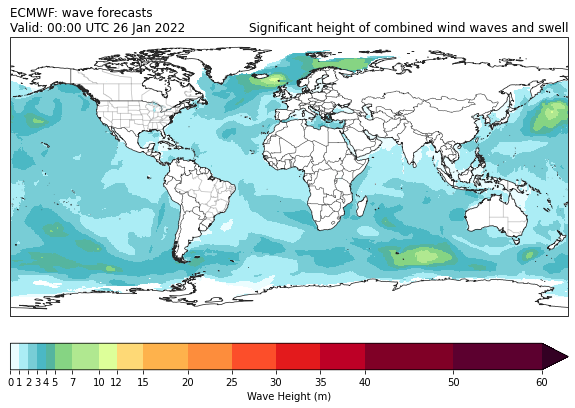

In [14]:
ax = common_features("50m", crs=ds.herbie.crs, figsize=[10, 10]).STATES().BORDERS().ax
p = ax.pcolormesh(
    ds.longitude, ds.latitude, ds.swh, transform=pc, **cm_wave_height(units='m').cmap_kwargs
)
plt.colorbar(p, ax=ax, orientation="horizontal", pad=0.05, **cm_wave_height(units='m').cbar_kwargs)

ax.set_title(
    f"{ds.model.upper()}: {H.product_description}\nValid: {ds.valid_time.dt.strftime('%H:%M UTC %d %b %Y').item()}",
    loc="left",
)
ax.set_title(ds.swh.GRIB_name, loc="right")


## Ensemble Forecast Products

In [15]:
H = Herbie('2022-01-26 00:00', model='ecmwf', product='enfo')
ds = H.xarray(':2t:')
ds

🏋🏻‍♂️ Found 2022-Jan-26 00:00 UTC F00 [ECMWF] [product=enfo] GRIB2 file from azure and index file from azure.                                                                                                                                                       
📇 Download subset: [ECMWF] model [enfo] product run at 2022-Jan-26 00:00 UTC F00                                                            
 cURL from https://ai4edataeuwest.blob.core.windows.net/ecmwf/20220126/00z/0p4-beta/enfo/20220126000000-0h-enfo-ef.grib2
   1: GRIB_message=1   :2t:sfc:29:g:0001:od:pf:enfo
   2: GRIB_message=4   :2t:sfc:2:g:0001:od:pf:enfo
   3: GRIB_message=20  :2t:sfc:19:g:0001:od:pf:enfo
   4: GRIB_message=39  :2t:sfc:38:g:0001:od:pf:enfo
   5: GRIB_message=45  :2t:sfc:22:g:0001:od:pf:enfo
   6: GRIB_message=52  :2t:sfc:12:g:0001:od:pf:enfo
   7: GRIB_message=53  :2t:sfc:14:g:0001:od:pf:enfo
   8: GRIB_message=55  :2t:sfc:7:g:0001:od:pf:enfo
   9: GRIB_message=58  :2t:sfc:39:g:0001:od:pf:enfo
  10: GRIB_

[<xarray.Dataset>
 Dimensions:              (number: 50, latitude: 451, longitude: 900)
 Coordinates:
   * number               (number) int64 1 2 3 4 5 6 7 8 ... 44 45 46 47 48 49 50
     time                 datetime64[ns] 2022-01-26
     step                 timedelta64[ns] 00:00:00
     heightAboveGround    float64 2.0
   * latitude             (latitude) float64 90.0 89.6 89.2 ... -89.2 -89.6 -90.0
   * longitude            (longitude) float64 -180.0 -179.6 ... 179.2 179.6
     valid_time           datetime64[ns] 2022-01-26
 Data variables:
     t2m                  (number, latitude, longitude) float32 246.5 ... 246.2
     gribfile_projection  object None
 Attributes:
     GRIB_edition:            2
     GRIB_centre:             ecmf
     GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
     GRIB_subCentre:          0
     Conventions:             CF-1.7
     institution:             European Centre for Medium-Range Weather Forecasts
     model:        

In [16]:
# Dataset with all 50 members
ds[0]

<xarray.Dataset>
Dimensions:              (number: 50, latitude: 451, longitude: 900)
Coordinates:
  * number               (number) int64 1 2 3 4 5 6 7 8 ... 44 45 46 47 48 49 50
    time                 datetime64[ns] 2022-01-26
    step                 timedelta64[ns] 00:00:00
    heightAboveGround    float64 2.0
  * latitude             (latitude) float64 90.0 89.6 89.2 ... -89.2 -89.6 -90.0
  * longitude            (longitude) float64 -180.0 -179.6 ... 179.2 179.6
    valid_time           datetime64[ns] 2022-01-26
Data variables:
    t2m                  (number, latitude, longitude) float32 246.5 ... 246.2
    gribfile_projection  object None
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    model:                   ecmwf
    product:                 enfo
    description:             ECMWF open data
    remote_grib:             https://ai4edataeuwest.blob.core.windows.net/ecm...
    local_grib:              /p/cwfs/blaylock/data/ecmwf/20220126/20220126000...

In [17]:
# This Dataset is of the mean of all the members, right?
ds[1]

<xarray.Dataset>
Dimensions:              (latitude: 451, longitude: 900)
Coordinates:
    number               int64 0
    time                 datetime64[ns] 2022-01-26
    step                 timedelta64[ns] 00:00:00
    heightAboveGround    float64 2.0
  * latitude             (latitude) float64 90.0 89.6 89.2 ... -89.2 -89.6 -90.0
  * longitude            (longitude) float64 -180.0 -179.6 ... 179.2 179.6
    valid_time           datetime64[ns] 2022-01-26
Data variables:
    t2m                  (latitude, longitude) float32 246.2 246.2 ... 246.3
    gribfile_projection  object None
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    model:                   ecmwf
    product:                 enfo
    description:             ECMWF open data
    remote_grib:             https://ai4edataeuwest.blob.core.windows.net/ecm...
    local_grib:              /p/cwfs/blaylock/data/ecmwf/20220126/20220126000...

In [18]:
H.idx

'https://ai4edataeuwest.blob.core.windows.net/ecmwf/20220126/00z/0p4-beta/enfo/20220126000000-0h-enfo-ef.index'

## Ensemble Wave Products

In [19]:
H = Herbie('2022-01-26 00:00', model='ecmwf', product='waef')
ds = H.xarray(None)
ds

🏋🏻‍♂️ Found 2022-Jan-26 00:00 UTC F00 [ECMWF] [product=waef] GRIB2 file from azure and index file from azure.                                                                                                                                                       
✅ Success! Downloaded ECMWF from azure               
	src: https://ai4edataeuwest.blob.core.windows.net/ecmwf/20220126/00z/0p4-beta/waef/20220126000000-0h-waef-ef.grib2
	dst: /p/cwfs/blaylock/data/ecmwf/20220126/20220126000000-0h-waef-ef.grib2
Note: Returning a list of [6] xarray.Datasets because of multiple hypercubes.


[<xarray.Dataset>
 Dimensions:              (number: 50, latitude: 451, longitude: 900)
 Coordinates:
   * number               (number) int64 1 2 3 4 5 6 7 8 ... 44 45 46 47 48 49 50
     time                 datetime64[ns] 2022-01-26
     step                 timedelta64[ns] 00:00:00
     meanSea              float64 0.0
   * latitude             (latitude) float64 90.0 89.6 89.2 ... -89.2 -89.6 -90.0
   * longitude            (longitude) float64 -180.0 -179.6 ... 179.2 179.6
     valid_time           datetime64[ns] 2022-01-26
 Data variables:
     mp2                  (number, latitude, longitude) float32 nan nan ... nan
     swh                  (number, latitude, longitude) float32 nan nan ... nan
     mwd                  (number, latitude, longitude) float32 nan nan ... nan
     pp1d                 (number, latitude, longitude) float32 nan nan ... nan
     mwp                  (number, latitude, longitude) float32 nan nan ... nan
     gribfile_projection  object None
 Attribute

In [20]:
len(ds)

2

In [21]:
ds[0]

<xarray.Dataset>
Dimensions:              (number: 50, latitude: 451, longitude: 900)
Coordinates:
  * number               (number) int64 1 2 3 4 5 6 7 8 ... 44 45 46 47 48 49 50
    time                 datetime64[ns] 2022-01-26
    step                 timedelta64[ns] 00:00:00
    meanSea              float64 0.0
  * latitude             (latitude) float64 90.0 89.6 89.2 ... -89.2 -89.6 -90.0
  * longitude            (longitude) float64 -180.0 -179.6 ... 179.2 179.6
    valid_time           datetime64[ns] 2022-01-26
Data variables:
    mp2                  (number, latitude, longitude) float32 nan nan ... nan
    swh                  (number, latitude, longitude) float32 nan nan ... nan
    mwd                  (number, latitude, longitude) float32 nan nan ... nan
    pp1d                 (number, latitude, longitude) float32 nan nan ... nan
    mwp                  (number, latitude, longitude) float32 nan nan ... nan
    gribfile_projection  object None
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    model:                   ecmwf
    product:                 waef
    description:             ECMWF open data
    remote_grib:             https://ai4edataeuwest.blob.core.windows.net/ecm...
    local_grib:              /p/cwfs/blaylock/data/ecmwf/20220126/20220126000...

In [22]:
ds[1]

<xarray.Dataset>
Dimensions:              (latitude: 451, longitude: 900)
Coordinates:
    number               int64 0
    time                 datetime64[ns] 2022-01-26
    step                 timedelta64[ns] 00:00:00
    meanSea              float64 0.0
  * latitude             (latitude) float64 90.0 89.6 89.2 ... -89.2 -89.6 -90.0
  * longitude            (longitude) float64 -180.0 -179.6 ... 179.2 179.6
    valid_time           datetime64[ns] 2022-01-26
Data variables:
    mp2                  (latitude, longitude) float32 nan nan nan ... nan nan
    swh                  (latitude, longitude) float32 nan nan nan ... nan nan
    mwd                  (latitude, longitude) float32 nan nan nan ... nan nan
    pp1d                 (latitude, longitude) float32 nan nan nan ... nan nan
    mwp                  (latitude, longitude) float32 nan nan nan ... nan nan
    gribfile_projection  object None
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    model:                   ecmwf
    product:                 waef
    description:             ECMWF open data
    remote_grib:             https://ai4edataeuwest.blob.core.windows.net/ecm...
    local_grib:              /p/cwfs/blaylock/data/ecmwf/20220126/20220126000...

In [33]:
H = Herbie('2022-01-26', model='ecmwf', product='enfo')
H.read_idx()

🏋🏻‍♂️ Found 2022-Jan-26 00:00 UTC F00 [ECMWF] [product=enfo] GRIB2 file from azure and index file from azure.                                                                                                                                                       


,start_byte,end_byte,range,reference_time,valid_time,step,param,levelist,levtype,number,domain,expver,class,type,stream,search_this
grib_message,,,,,,,,,,,,,,,,
1,0,609069,0-609069,2022-01-26,2022-01-26,0 days,2t,NaN,sfc,29,g,0001,od,pf,enfo,:2t:sfc:29:g:0001:od:pf:enfo
2,609069,1218138,609069-1218138,2022-01-26,2022-01-26,0 days,10u,NaN,sfc,27,g,0001,od,pf,enfo,:10u:sfc:27:g:0001:od:pf:enfo
3,1218138,1827207,1218138-1827207,2022-01-26,2022-01-26,0 days,10v,NaN,sfc,14,g,0001,od,pf,enfo,:10v:sfc:14:g:0001:od:pf:enfo
4,1827207,2436276,1827207-2436276,2022-01-26,2022-01-26,0 days,2t,NaN,sfc,2,g,0001,od,pf,enfo,:2t:sfc:2:g:0001:od:pf:enfo
5,2436276,3045345,2436276-3045345,2022-01-26,2022-01-26,0 days,10u,NaN,sfc,43,g,0001,od,pf,enfo,:10u:sfc:43:g:0001:od:pf:enfo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4178,2574120261,2574932280,2574120261-2574932280,2022-01-26,2022-01-26,0 days,d,200,pl,20,g,0001,od,pf,enfo,:d:200:pl:20:g:0001:od:pf:enfo
4179,2574932280,2575744299,2574932280-2575744299,2022-01-26,2022-01-26,0 days,d,200,pl,41,g,0001,od,pf,enfo,:d:200:pl:41:g:0001:od:pf:enfo
4180,2575744299,2576556318,2575744299-2576556318,2022-01-26,2022-01-26,0 days,d,200,pl,4,g,0001,od,pf,enfo,:d:200:pl:4:g:0001:od:pf:enfo
